# Day 5: Classification for Trading Signals
## Week 4: Machine Learning Foundations

---

**Learning Objectives:**
- Frame trading as a classification problem
- Implement logistic regression and tree models
- Handle class imbalance
- Evaluate with appropriate metrics

In [8]:
# Day 5 Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, classification_report,
                             roc_auc_score, roc_curve)
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')

# Load data
df = pd.read_csv('../datasets/raw_data/combined_adjusted_close.csv', 
                 index_col='Date', parse_dates=True)
prices = df[['AAPL', 'MSFT', 'SPY', 'JPM']].dropna()
returns = prices.pct_change().dropna()

print("=" * 60)
print("CLASSIFICATION FOR TRADING SIGNALS - DAY 5")
print("=" * 60)

CLASSIFICATION FOR TRADING SIGNALS - DAY 5


## 1. Framing as Classification

Instead of predicting exact returns, predict:
- **Binary**: Up (1) or Down (0)
- **Multi-class**: Strong up, Up, Flat, Down, Strong down

In [9]:
# Create binary target
print("=" * 60)
print("CREATING CLASSIFICATION TARGET")
print("=" * 60)

# Binary classification: next day return > 0
target = (returns['SPY'] > 0).astype(int)

print(f"\nClass distribution:")
print(f"  Down (0): {(target == 0).sum()} ({(target == 0).mean():.1%})")
print(f"  Up (1):   {(target == 1).sum()} ({(target == 1).mean():.1%})")

# Create features
def create_features(returns, prices, target_col):
    """Create feature matrix for classification."""
    features = pd.DataFrame(index=returns.index)
    
    # Lagged returns
    for lag in range(1, 6):
        features[f'ret_lag_{lag}'] = returns[target_col].shift(lag)
    
    # Technical features
    p = prices[target_col]
    r = returns[target_col]
    
    # SMA position
    for w in [5, 10, 20]:
        features[f'above_sma_{w}'] = (p > p.rolling(w).mean()).astype(int).shift(1)
        features[f'sma_dist_{w}'] = (p / p.rolling(w).mean() - 1).shift(1)
    
    # Volatility
    features['vol_5'] = r.rolling(5).std().shift(1)
    features['vol_20'] = r.rolling(20).std().shift(1)
    
    # RSI
    delta = p.diff()
    gain = delta.where(delta > 0, 0).rolling(14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
    features['rsi'] = (100 - 100 / (1 + gain / loss)).shift(1)
    
    # Momentum
    features['mom_5'] = p.pct_change(5).shift(1)
    features['mom_20'] = p.pct_change(20).shift(1)
    
    # Cross-asset
    for col in returns.columns:
        if col != target_col:
            features[f'{col}_ret_lag1'] = returns[col].shift(1)
    
    return features

X = create_features(returns, prices, 'SPY')
y = target

# Align and clean
data = X.join(y.rename('target')).dropna()
X = data.drop('target', axis=1)
y = data['target']

print(f"\nFeatures: {X.shape[1]}")
print(f"Samples: {len(X)}")

CREATING CLASSIFICATION TARGET

Class distribution:
  Down (0): 783 (44.2%)
  Up (1):   987 (55.8%)

Features: 19
Samples: 1750


## 2. Logistic Regression

In [10]:
# Logistic regression
print("=" * 60)
print("LOGISTIC REGRESSION")
print("=" * 60)

# Train-test split
split = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit model
log_reg = LogisticRegression(C=0.1, max_iter=1000, random_state=42)
log_reg.fit(X_train_scaled, y_train)

# Predict
y_pred = log_reg.predict(X_test_scaled)
y_prob = log_reg.predict_proba(X_test_scaled)[:, 1]

# Metrics
print(f"\nTest Set Results:")
print(f"  Accuracy:  {accuracy_score(y_test, y_pred):.4f}")
print(f"  Precision: {precision_score(y_test, y_pred):.4f}")
print(f"  Recall:    {recall_score(y_test, y_pred):.4f}")
print(f"  F1 Score:  {f1_score(y_test, y_pred):.4f}")
print(f"  AUC-ROC:   {roc_auc_score(y_test, y_prob):.4f}")

# Confusion matrix
print(f"\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Compare to baseline
baseline_acc = (y_test == 1).mean()  # Always predict up
print(f"\nBaseline (always predict 'up'): {baseline_acc:.4f}")

LOGISTIC REGRESSION

Test Set Results:
  Accuracy:  0.5314
  Precision: 0.5599
  Recall:    0.8607
  F1 Score:  0.6784
  AUC-ROC:   0.4771

Confusion Matrix:
[[ 13 136]
 [ 28 173]]

Baseline (always predict 'up'): 0.5743


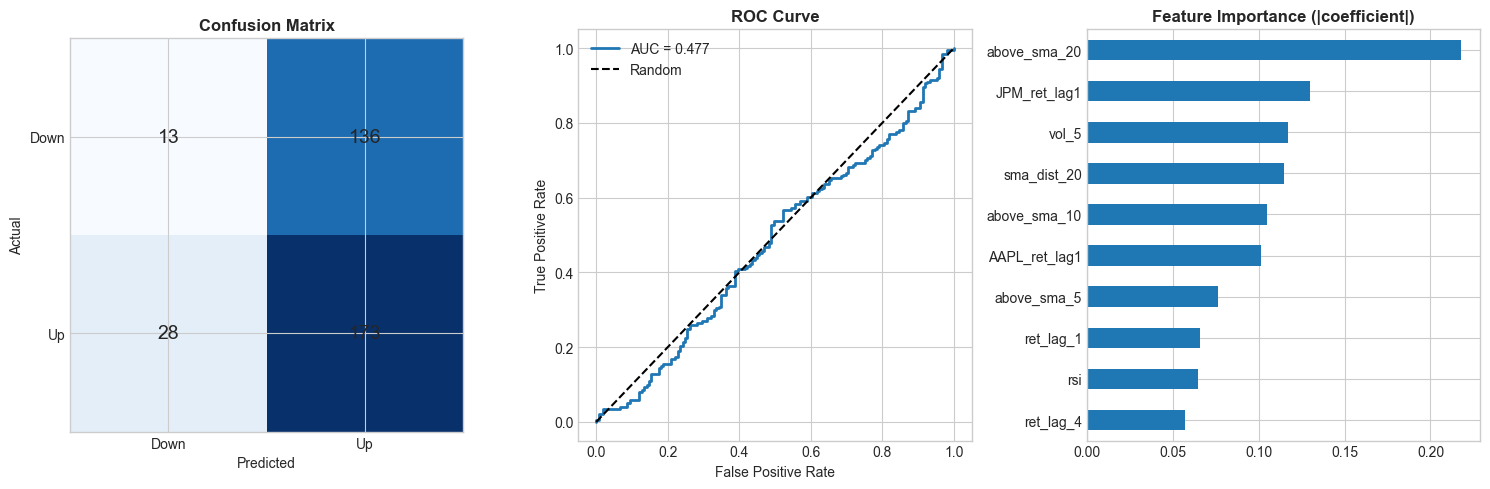

In [11]:
# Visualize results
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Confusion matrix heatmap
im = axes[0].imshow(cm, cmap='Blues')
axes[0].set_xticks([0, 1])
axes[0].set_yticks([0, 1])
axes[0].set_xticklabels(['Down', 'Up'])
axes[0].set_yticklabels(['Down', 'Up'])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('Confusion Matrix', fontweight='bold')

for i in range(2):
    for j in range(2):
        axes[0].text(j, i, cm[i, j], ha='center', va='center', fontsize=14)

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
axes[1].plot(fpr, tpr, lw=2, label=f'AUC = {roc_auc_score(y_test, y_prob):.3f}')
axes[1].plot([0, 1], [0, 1], 'k--', label='Random')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve', fontweight='bold')
axes[1].legend()

# Feature importance
importance = pd.Series(np.abs(log_reg.coef_[0]), index=X.columns).sort_values(ascending=True)
importance.tail(10).plot(kind='barh', ax=axes[2])
axes[2].set_title('Feature Importance (|coefficient|)', fontweight='bold')

plt.tight_layout()
plt.show()

## 3. Tree-Based Models

In [12]:
# Compare multiple models
print("=" * 60)
print("MODEL COMPARISON")
print("=" * 60)

models = {
    'Logistic Regression': LogisticRegression(C=0.1, max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, max_depth=3, random_state=42)
}

results = []
for name, model in models.items():
    if 'Logistic' in name:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]
    
    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'AUC': roc_auc_score(y_test, y_prob)
    })

results_df = pd.DataFrame(results)
print("\n" + results_df.to_string(index=False))

MODEL COMPARISON

              Model  Accuracy  Precision   Recall       F1      AUC
Logistic Regression  0.531429   0.559871 0.860697 0.678431 0.477111
      Random Forest  0.557143   0.570122 0.930348 0.706994 0.467528
  Gradient Boosting  0.540000   0.574074 0.771144 0.658174 0.504291


## 4. Trading Simulation with Predictions

TRADING SIMULATION

Strategy Results by Threshold:
 Threshold  Total Return   Sharpe  Trades  % Time in Market
      0.50      0.001651 0.727943      50          0.882857
      0.52      0.001139 0.525145      62          0.817143
      0.55      0.001215 0.587953     103          0.651429
      0.60      0.000719 0.437084      99          0.217143


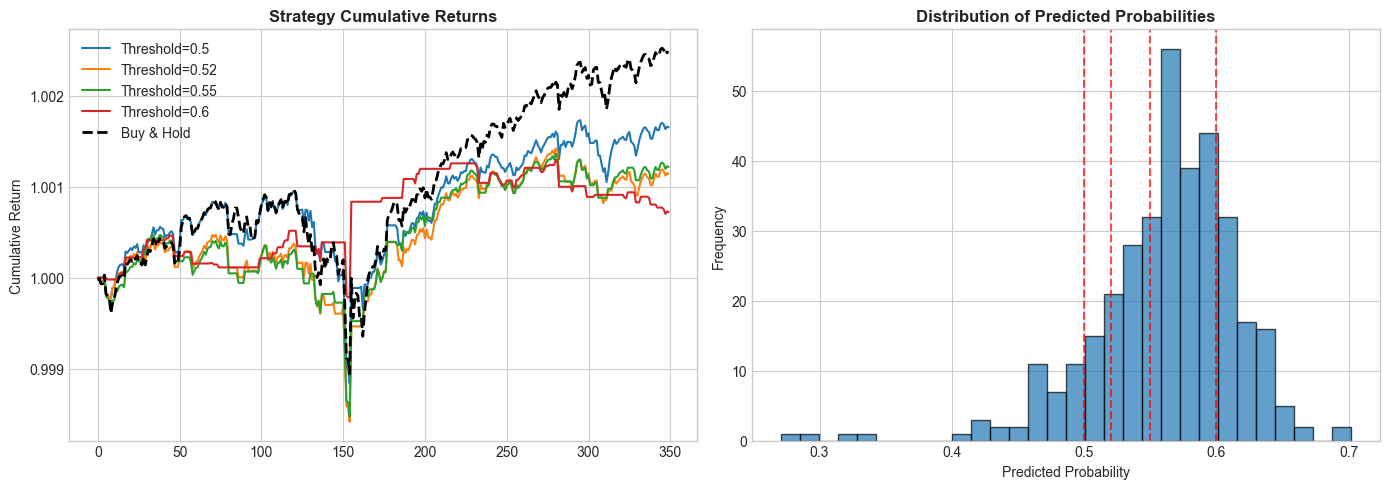

In [13]:
# Trading simulation
print("=" * 60)
print("TRADING SIMULATION")
print("=" * 60)

# Use logistic regression predictions
log_reg.fit(X_train_scaled, y_train)
y_prob = log_reg.predict_proba(X_test_scaled)[:, 1]

# Get actual returns for test period
test_returns = returns['SPY'].loc[X_test.index]

# Strategy: Long when P(up) > threshold
thresholds = [0.5, 0.52, 0.55, 0.6]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

strategy_results = []
for threshold in thresholds:
    # Position: 1 if probability > threshold, 0 otherwise
    position = (y_prob > threshold).astype(int)
    
    # Strategy return (only long when predicting up)
    strategy_return = position * test_returns.values
    
    # Cumulative returns
    cumret = (1 + strategy_return / 100).cumprod()
    
    # Metrics
    total_ret = cumret[-1] - 1
    sharpe = (strategy_return.mean() / strategy_return.std()) * np.sqrt(252)
    n_trades = (np.diff(position) != 0).sum()
    
    strategy_results.append({
        'Threshold': threshold,
        'Total Return': total_ret,
        'Sharpe': sharpe,
        'Trades': n_trades,
        '% Time in Market': position.mean()
    })
    
    axes[0].plot(cumret, label=f'Threshold={threshold}')

# Buy and hold
bh_cumret = (1 + test_returns / 100).cumprod()
axes[0].plot(bh_cumret.values, 'k--', lw=2, label='Buy & Hold')
axes[0].set_title('Strategy Cumulative Returns', fontweight='bold')
axes[0].legend()
axes[0].set_ylabel('Cumulative Return')

# Results table
results_df = pd.DataFrame(strategy_results)
print("\nStrategy Results by Threshold:")
print(results_df.to_string(index=False))

# Probability distribution
axes[1].hist(y_prob, bins=30, alpha=0.7, edgecolor='black')
for t in thresholds:
    axes[1].axvline(t, color='red', linestyle='--', alpha=0.7)
axes[1].set_xlabel('Predicted Probability')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Predicted Probabilities', fontweight='bold')

plt.tight_layout()
plt.show()

## 5. Time Series Cross-Validation

In [14]:
# Time series CV
print("=" * 60)
print("TIME SERIES CROSS-VALIDATION")
print("=" * 60)

tscv = TimeSeriesSplit(n_splits=5)

cv_results = []
for name, model in models.items():
    if 'Logistic' in name:
        scores = cross_val_score(model, scaler.fit_transform(X), y, cv=tscv, scoring='roc_auc')
    else:
        scores = cross_val_score(model, X, y, cv=tscv, scoring='roc_auc')
    
    cv_results.append({
        'Model': name,
        'Mean AUC': scores.mean(),
        'Std AUC': scores.std(),
        'Min AUC': scores.min(),
        'Max AUC': scores.max()
    })

cv_df = pd.DataFrame(cv_results)
print("\nCross-Validation AUC Scores:")
print(cv_df.to_string(index=False))

print("\n💡 Note: AUC ~0.5 means no better than random")
print("   Even small improvements (0.52-0.55) can be profitable with good execution")

TIME SERIES CROSS-VALIDATION

Cross-Validation AUC Scores:
              Model  Mean AUC  Std AUC  Min AUC  Max AUC
Logistic Regression  0.502047 0.053904 0.416113 0.579685
      Random Forest  0.499778 0.019291 0.464530 0.514978
  Gradient Boosting  0.499209 0.028393 0.448065 0.532929

💡 Note: AUC ~0.5 means no better than random
   Even small improvements (0.52-0.55) can be profitable with good execution


## 📝 Key Takeaways - Day 5

### Classification vs Regression:
| Approach | Target | Use Case |
|----------|--------|----------|
| Regression | Exact return | Position sizing |
| Binary | Up/Down | Simple signals |
| Multi-class | Strength | Conviction levels |

### Metrics for Trading:
- **Accuracy**: Overall correct predictions
- **Precision**: When we predict up, how often correct?
- **AUC**: Overall discriminative ability
- **Profit**: Ultimate test (include costs!)

### Reality Check:
- >55% accuracy is impressive for daily returns
- AUC > 0.52 can be profitable
- Transaction costs matter A LOT

### Interview Questions:
- "How would you frame return prediction as classification?"
- "What metrics matter for a trading classifier?"
- "Why might high accuracy not mean profitability?"